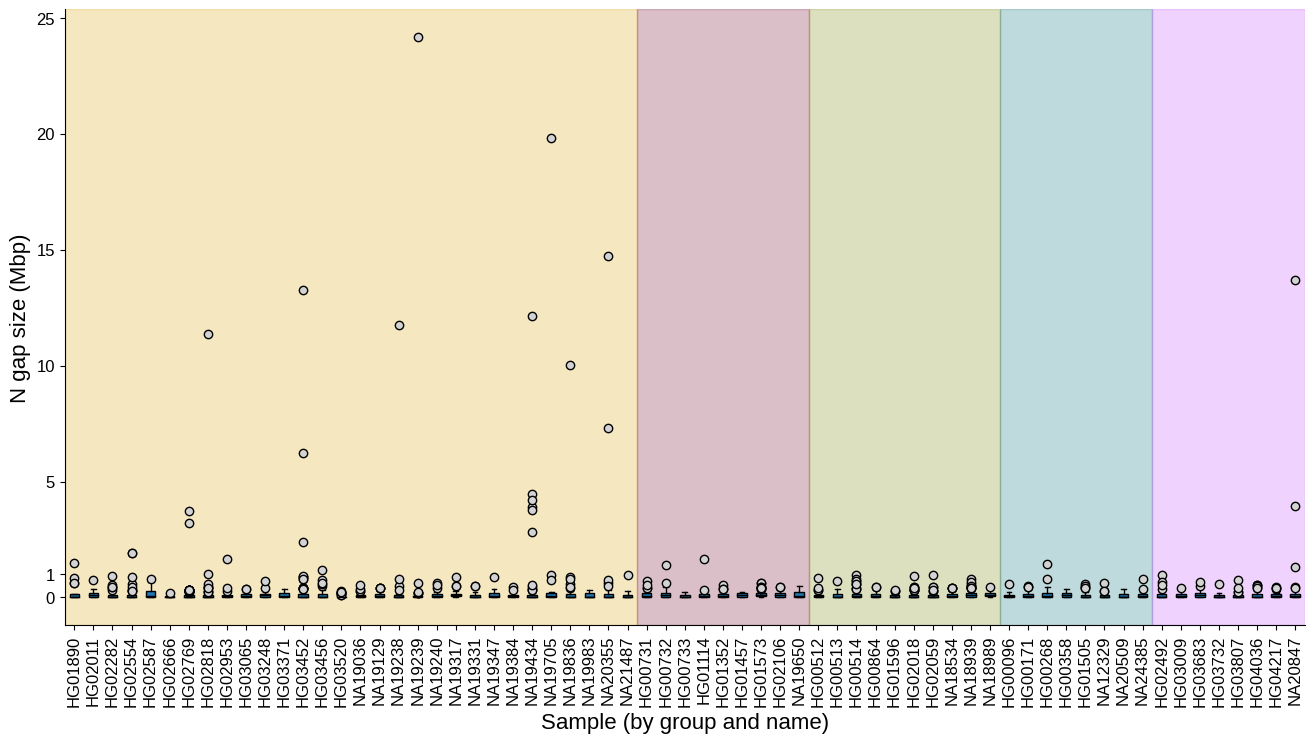

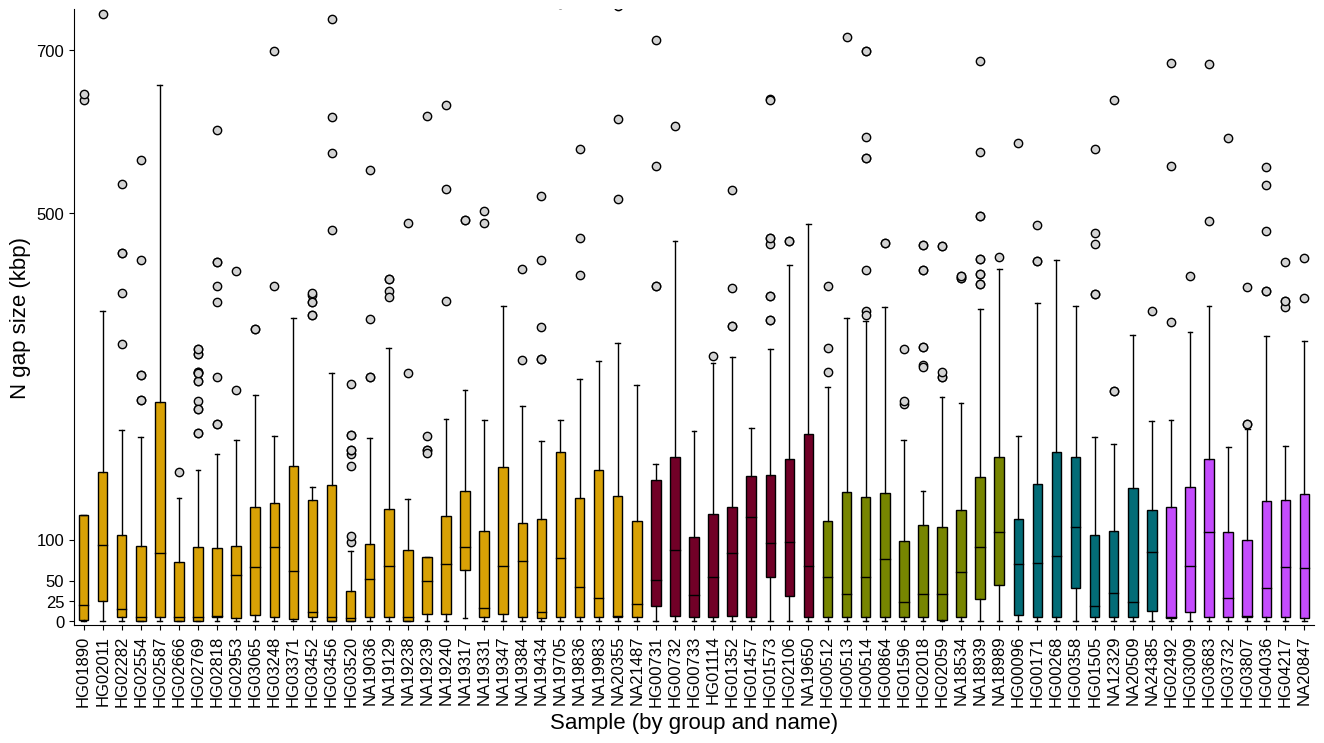

In [3]:
%run -n "../../00_project_config.ipynb"
%run -n "../../05_plot_config.ipynb"
%run -n "../../10_assm_stats.ipynb"

import collections as col
import statistics as stat
import numpy as np
import matplotlib.pyplot as plt

cache_ngap_summary = PROJECT_BASE.joinpath(
    "notebooks", ".cache", "contigs_with_ngap.tsv.gz"
)

annotation_source = PROJECT_DATA_ROOT.joinpath(
    "2024_ngaps", "hgsvc3"
)

def load_annotation(file_path):
    
    columns = ["chrom", "start", "end", "sample", "length"]
    df = pd.read_csv(file_path, sep="\t", header=None, comment="#", names=columns)
    df["length"] = (df["length"] / 1e3).round(1)
    return df["sample"].iloc[0], df["length"].values, set(df["chrom"].values)


def read_all_annotations():
    
    ngaps = dict()
    ngap_summary = []
    for bed_file in annotation_source.glob("*ngaps.bed"):
        sample, gap_sizes, contigs = load_annotation(bed_file)
        if "ps" in sample:
            sample = sample.split(".")[0]
        assert sample not in ngaps
        ngaps[sample] = gap_sizes
        ngap_summary.extend(
            [(sample, contig) for contig in sorted(contigs)]
        )
    df = pd.DataFrame.from_records(ngap_summary, columns=["sample", "contig"])
    return ngaps, df


def plot_ngaps_summary(ngaps, focus=False):
    
    sort_order = get_samples_ordered_by_pop()
    
    boxes = []
    labels = []
    colors = []
    pop_boundaries = col.defaultdict(list)
    for pos, (pop, sample) in enumerate(sort_order, start=1):
        sample_gaps = ngaps[sample]
        boxes.append(sample_gaps)
        labels.append(sample)
        colors.append(get_pop_color(sample))
        pop_boundaries[pop].append(pos)
        
    fig, ax = plt.subplots(figsize=(16,8))
    boxplot = ax.boxplot(
        boxes,
        labels=labels
    )
    
    ax.tick_params(axis='x', labelrotation=90)
            
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
        
    if focus:
        yticks = [0, 25, 50, 100, 500, 700]
        labels = list(map(str, yticks))
        ax.set_ylabel("N gap size (kbp)")
        ax.set_ylim(-5, 750)
        for patch, color in zip(boxplot["boxes"], colors):
            patch.set_facecolor(color)        
    else:
        for pop, positions in pop_boundaries.items():
            span_from = min(positions)
            span_to = max(positions)
            color = colors[span_from-1]
            color2 = colors[span_to-1]
            assert color==color2
            ax.axvspan(span_from-0.5, span_to+0.5, alpha=0.25, color=color)
        yticks = [0, int(1e3), int(5e3), int(1e4), int(15e3), int(2e4), int(25e3)]
        labels = ["0", "1", "5", "10", "15", "20", "25"]
        ax.set_ylabel("N gap size (Mbp)")
    
    ax.set_yticks(yticks)
    ax.set_yticklabels(labels)
    
    ax.set_xlabel("Sample (by group and name)")
    
    return
    

def plot_ngaps_read_input(ngaps, read_stat, label):
    
    all_x = HGSVC_SAMPLES.loc[:, read_stat].values
    all_y = [stat.median(ngaps[sample]) for sample in HGSVC_ALL]
    colors = [get_pop_color(sample) for sample in HGSVC_ALL]
    
    
    fig, ax = plt.subplots(figsize=(8,8))
    
    ax.scatter(
        all_x,
        all_y,
        c=colors,
        marker="s"
    )
    
    ax.set_ylabel("Median N gap size (kbp)")
    ax.set_xlabel(f"{label}")
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    return
    
    
ngaps, ngap_summary = read_all_annotations()
ngap_summary.to_csv(cache_ngap_summary, sep="\t", header=True, index=False)



_ = plot_ngaps_summary(ngaps, False)
_ = plot_ngaps_summary(ngaps, True)

#_ = plot_ngaps_read_input(ngaps, "hifi_cov", "HiFi coverage (x-fold)")
#_ = plot_ngaps_read_input(ngaps, "ontul_cov", "ONT-UL coverage (x-fold)")


    
    